In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

# Network definition
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    
    def forward(self, x): 
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)


In [3]:
gpuid = 0
model = L.Classifier(MLP( 500 , 10))

#GPU
chainer.backends.cuda.get_device_from_id( 0 ).use()
model.to_gpu()  # Copy the model to the GPU

In [4]:
chainer.print_runtime_info()

Platform: Linux-3.10.0-862.3.2.el7.x86_64-x86_64-with-centos-7.5.1804-Core
Chainer: 5.1.0
NumPy: 1.14.2
CuPy:
  CuPy Version          : 5.1.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9010
  CUDA Driver Version   : 9010
  CUDA Runtime Version  : 9010
  cuDNN Build Version   : 7005
  cuDNN Version         : 7005
  NCCL Build Version    : None
iDeep: Not Available


In [20]:
import math
import warnings

import numpy as np

from chainer import backend
from chainer.backends import cuda
from chainer.backends import intel64
from chainer import optimizer
from chainer import Variable
import chainer.functions as F

_default_hyperparam = optimizer.Hyperparameter()
_default_hyperparam.epsilon = 1
_default_hyperparam.delta = 0.6


class HamiltonianRule(optimizer.UpdateRule):
    
    """ Update rule of Hamiltonian Gradient Descent.
    
    sample ver.
    """
    
    _kernel = None
    _kernel_2 = None
    
    def __init__(self, parent_hyperparam=None,
                 epsilon=None, delta=None, body=None, tail=None, expon=None):
        super(HamiltonianRule, self).__init__(
            parent_hyperparam or _default_hyperparam)
        if epsilon is not None:
            self.hyperparam.epsilon = epsilon
        if delta is not None:
            self.hyperparam.delta = delta
            
    def init_state(self, param):
        xp = backend.get_array_module(param.data)
        with cuda.get_device_from_array(param.data):
            self.state['p'] = xp.zeros_like(param.data) 
        
        
    def update_core_cpu(self, param):
        grad = param.grad
        if grad is None:
            return
        hp = self.hyperparam
        p = self.state['p']
        
        p = hp.delta * p - hp.epsilon * hp.delta * grad
        sqsum = np.vdot(p,p)
        
        param.data += hp.epsilon / (1.0 + sqsum) * p

    def update_core_gpu(self, param):
        grad = param.grad
        if grad is None:
            return
        hp = self.hyperparam
        p = self.state['p']
        
        if HamiltonianRule._kernel is None:
            HamiltonianRule._kernel = cuda.elementwise(
                'T delta, T epsilon, T grad', 'T p',
                'p *= delta; p -= epsilon * delta * grad;',
                'Hamiltonian_p')
        HamiltonianRule._kernel(hp.delta, hp.epsilon, grad, p)

        sqsum = cuda.cupy.vdot(p,p)
        if HamiltonianRule._kernel_2 is None:
            HamiltonianRule._kernel_2 = cuda.elementwise(
                'T epsilon, T p, T sqsum', 'T param', 
                'param += epsilon * p / (1.0 + sqsum)', 'Hamiltonian_q')
        
        HamiltonianRule._kernel_2(hp.epsilon, p, sqsum, param.data)

class Hamiltonian(optimizer.GradientMethod):
    def __init__(self,
                  epsilon=_default_hyperparam.epsilon,
                  delta=_default_hyperparam.delta):
        
        super(Hamiltonian, self).__init__()
        self.hyperparam.epsilon = epsilon
        self.hyperparam.delta = delta
        
    epsilon = optimizer.HyperparameterProxy('epsilon')
    delta = optimizer.HyperparameterProxy('delta')
    
    def create_update_rule(self):
        return HamiltonianRule(self.hyperparam)
        

In [21]:
gpuid = 0
model = L.Classifier(MLP( 500 , 10))

#GPU
chainer.backends.cuda.get_device( 0 ).use()
model.to_gpu()  # Copy the model to the GPU

optimizer = Hamiltonian(epsilon=1, delta=.6)
optimizer.setup(model)

# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train, 100)
test_iter = chainer.iterators.SerialIterator(test, 100, repeat=False, shuffle=False)

# Set up a trainer
updater = training.updaters.StandardUpdater( train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (100, 'epoch'))

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

trainer.extend(extensions.dump_graph('main/loss'))
#frequency = 10
#trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport(log_name="Hamiltonian"))
#trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))


In [22]:
trainer.run()

In [23]:
hamiltonian_result = pd.read_json("./result/Hamiltonian")

In [9]:
gpuid = 0
model = L.Classifier(MLP( 500 , 10))

#GPU
chainer.backends.cuda.get_device_from_id( 0 ).use()
model.to_gpu()  # Copy the model to the GPU

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train, 100)
test_iter = chainer.iterators.SerialIterator(test, 100, repeat=False, shuffle=False)

# Set up a trainer
updater = training.updaters.StandardUpdater( train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (100, 'epoch'))

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

trainer.extend(extensions.dump_graph('main/loss'))
#frequency = 10
#trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport(log_name="Adam"))
#trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))


#trainer.extend(extensions.ProgressBar())

In [10]:
trainer.run()

In [11]:
#renamed manually
adam_result = pd.read_json("./result/Adam")

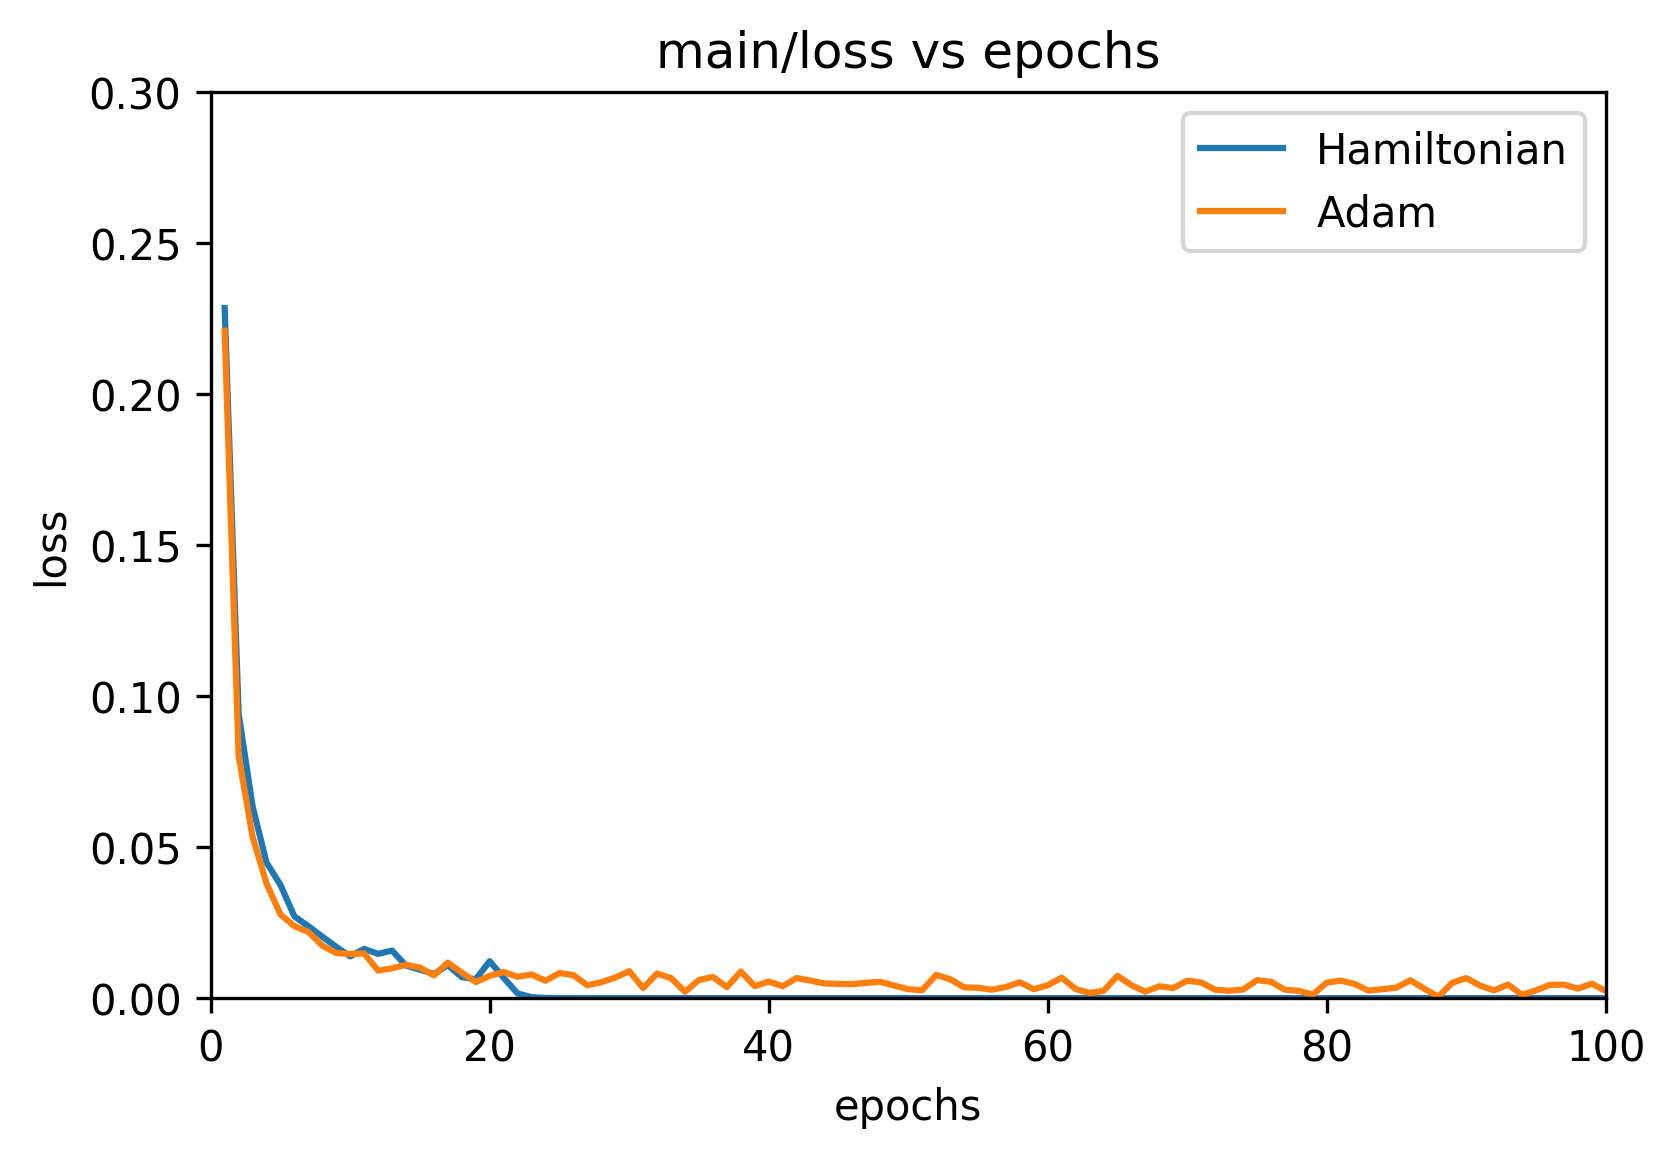

In [24]:
plt.figure(figsize=(6,4),dpi=300)
plt.ylim(0,.3)
plt.xlim(0,100)
plt.title("main/loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(hamiltonian_result["epoch"],hamiltonian_result["main/loss"], label='Hamiltonian')
plt.plot(adam_result["epoch"],adam_result["main/loss"], label='Adam')


plt.legend()

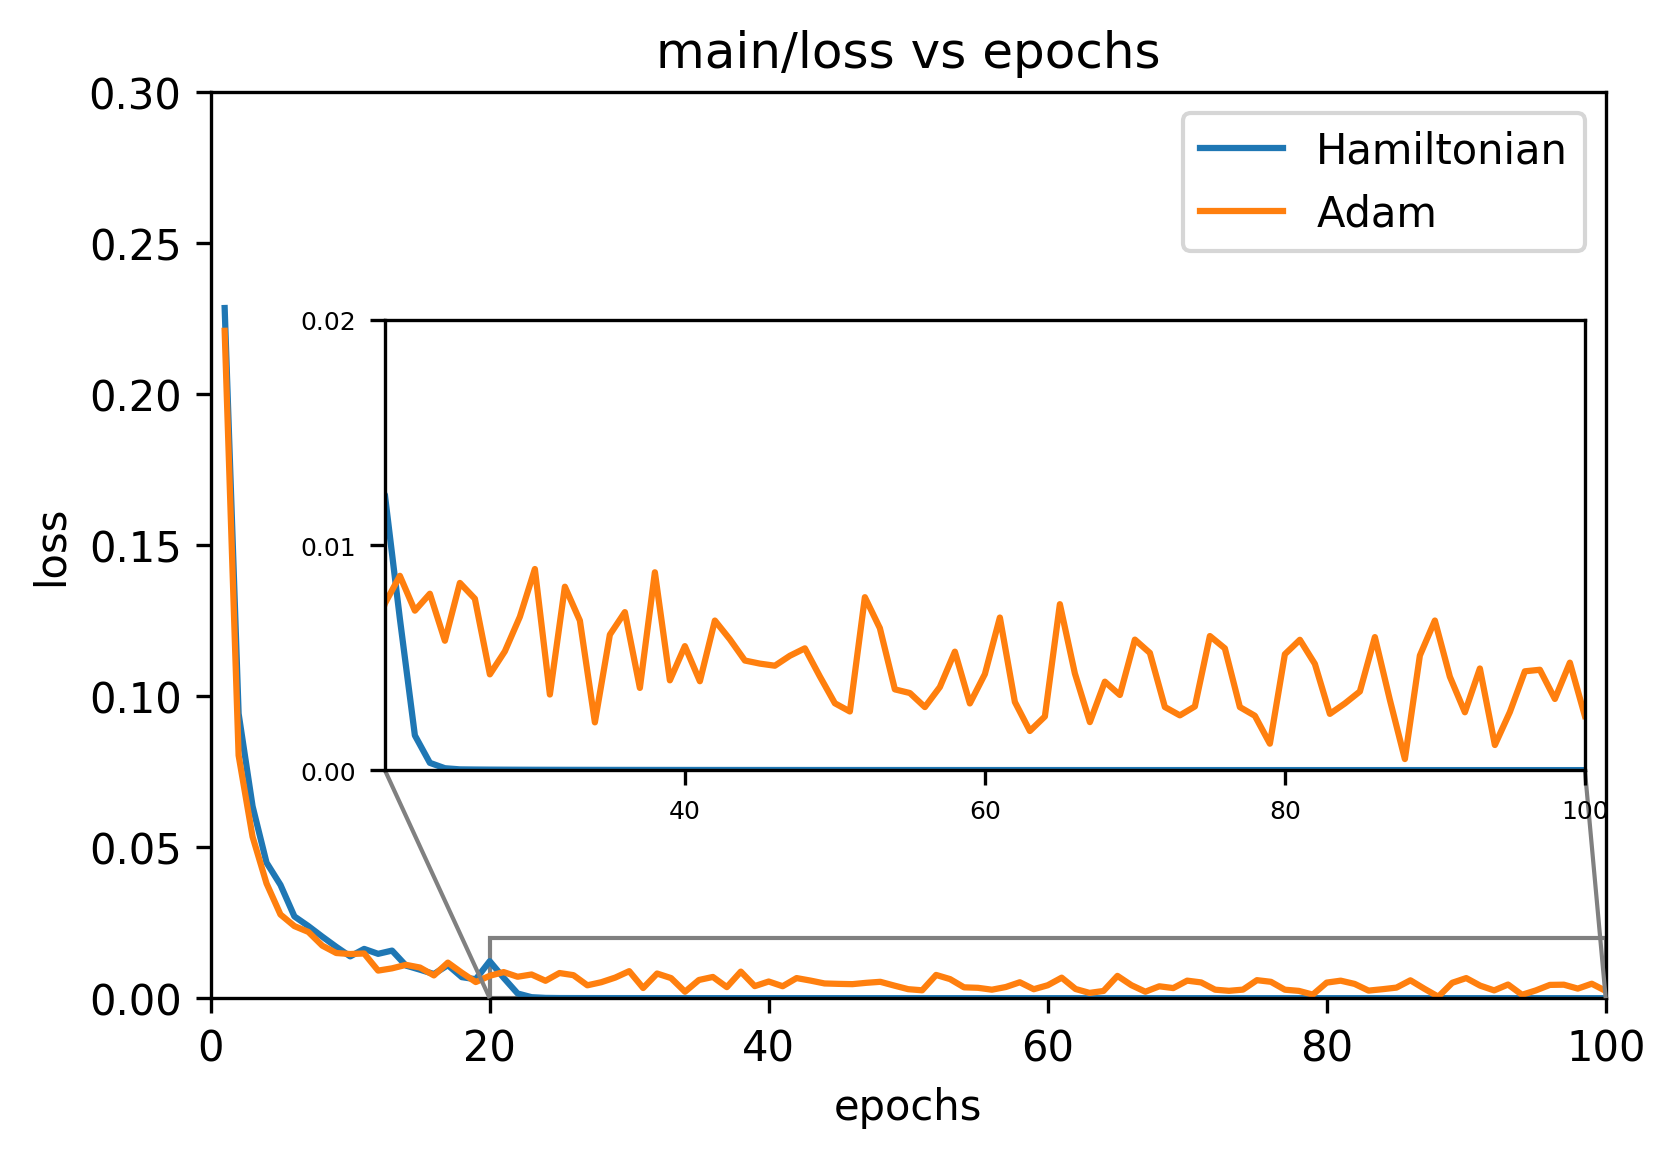

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
plt.title("main/loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0,.3)
plt.xlim(0,100)

axins = inset_axes(ax, 4,1.5 , loc=5)
axins.set_xlim(20,100)
axins.set_ylim(0,.02)

ax.plot(hamiltonian_result["epoch"],hamiltonian_result["main/loss"], label='Hamiltonian')
ax.plot(adam_result["epoch"],adam_result["main/loss"], label='Adam')

axins.plot(hamiltonian_result["epoch"],hamiltonian_result["main/loss"], label='Hamiltonian')
axins.plot(adam_result["epoch"],adam_result["main/loss"], label='Adam')

plt.xticks([40,60,80,100],fontsize=6)
plt.yticks([0,.01,.02],fontsize=6)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.5")

ax.legend(loc=1)


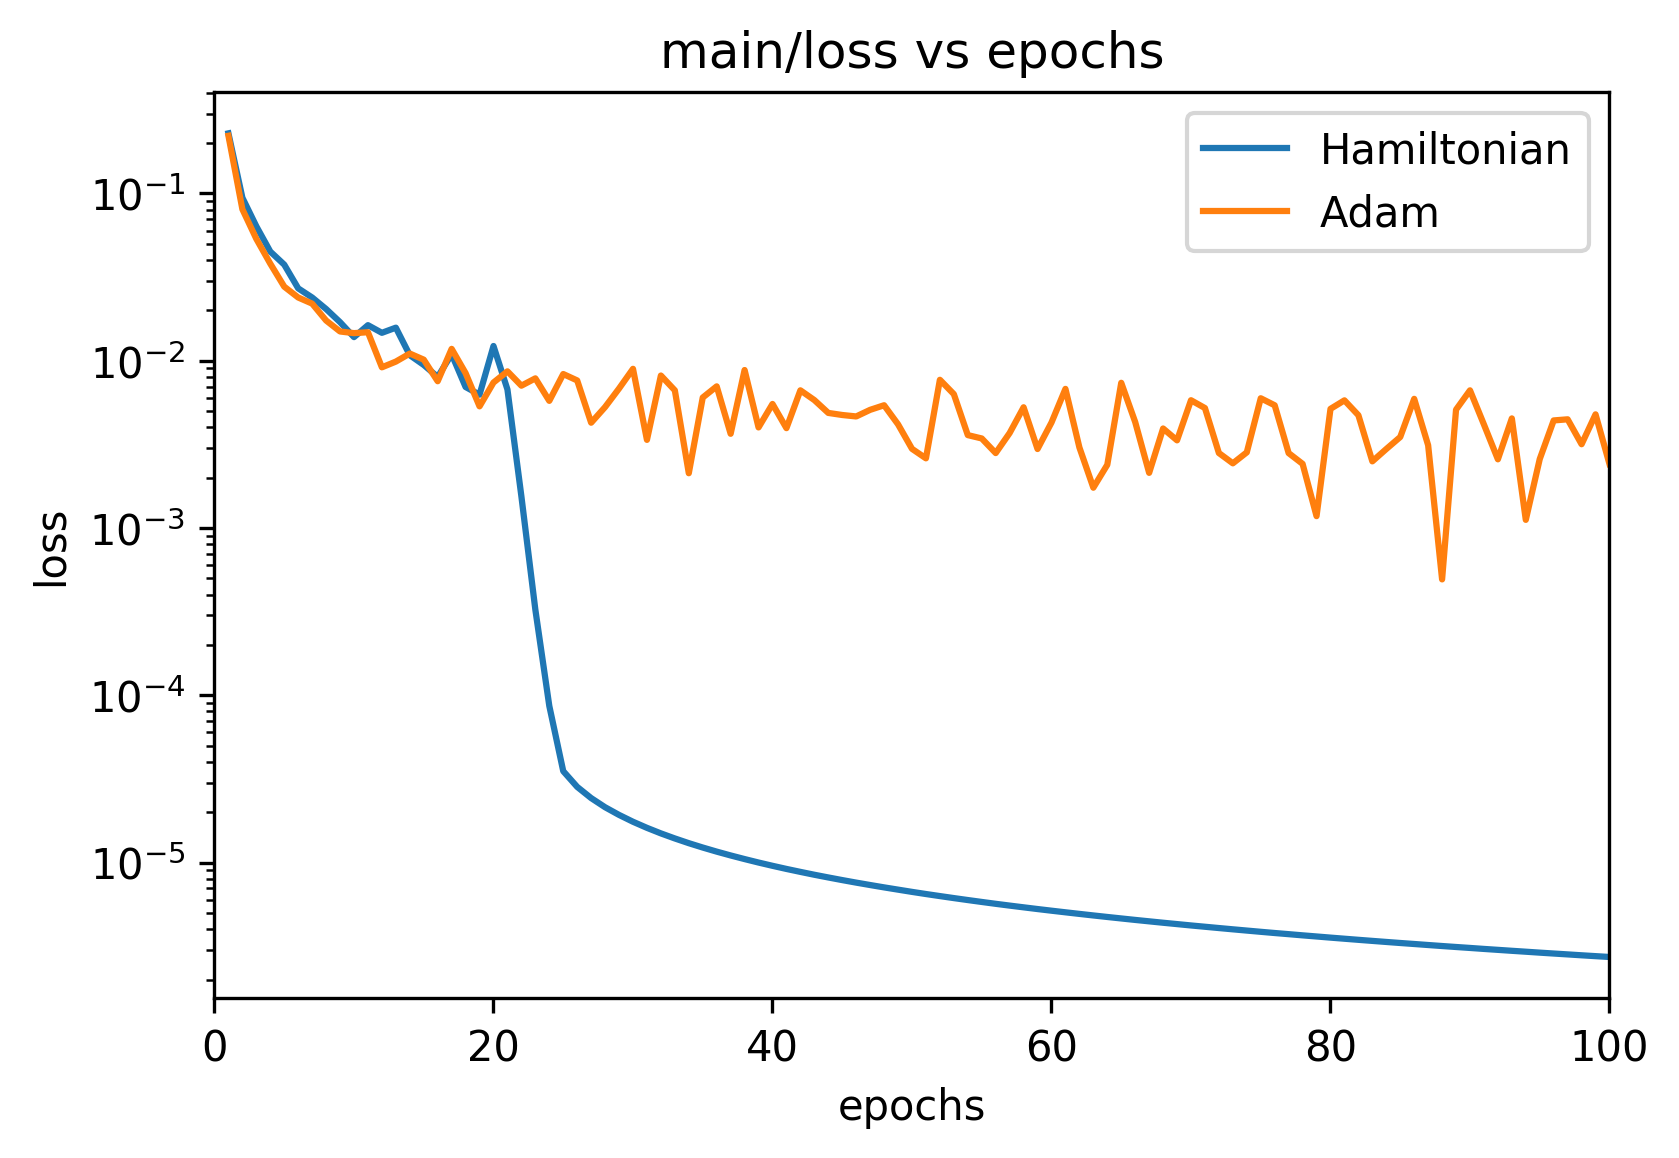

In [26]:
plt.figure(figsize=(6,4),dpi=300)
plt.yscale("log")
plt.xlim(0,100)
plt.title("main/loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(hamiltonian_result["epoch"],hamiltonian_result["main/loss"], label='Hamiltonian')
plt.plot(adam_result["epoch"],adam_result["main/loss"], label='Adam')


plt.legend()

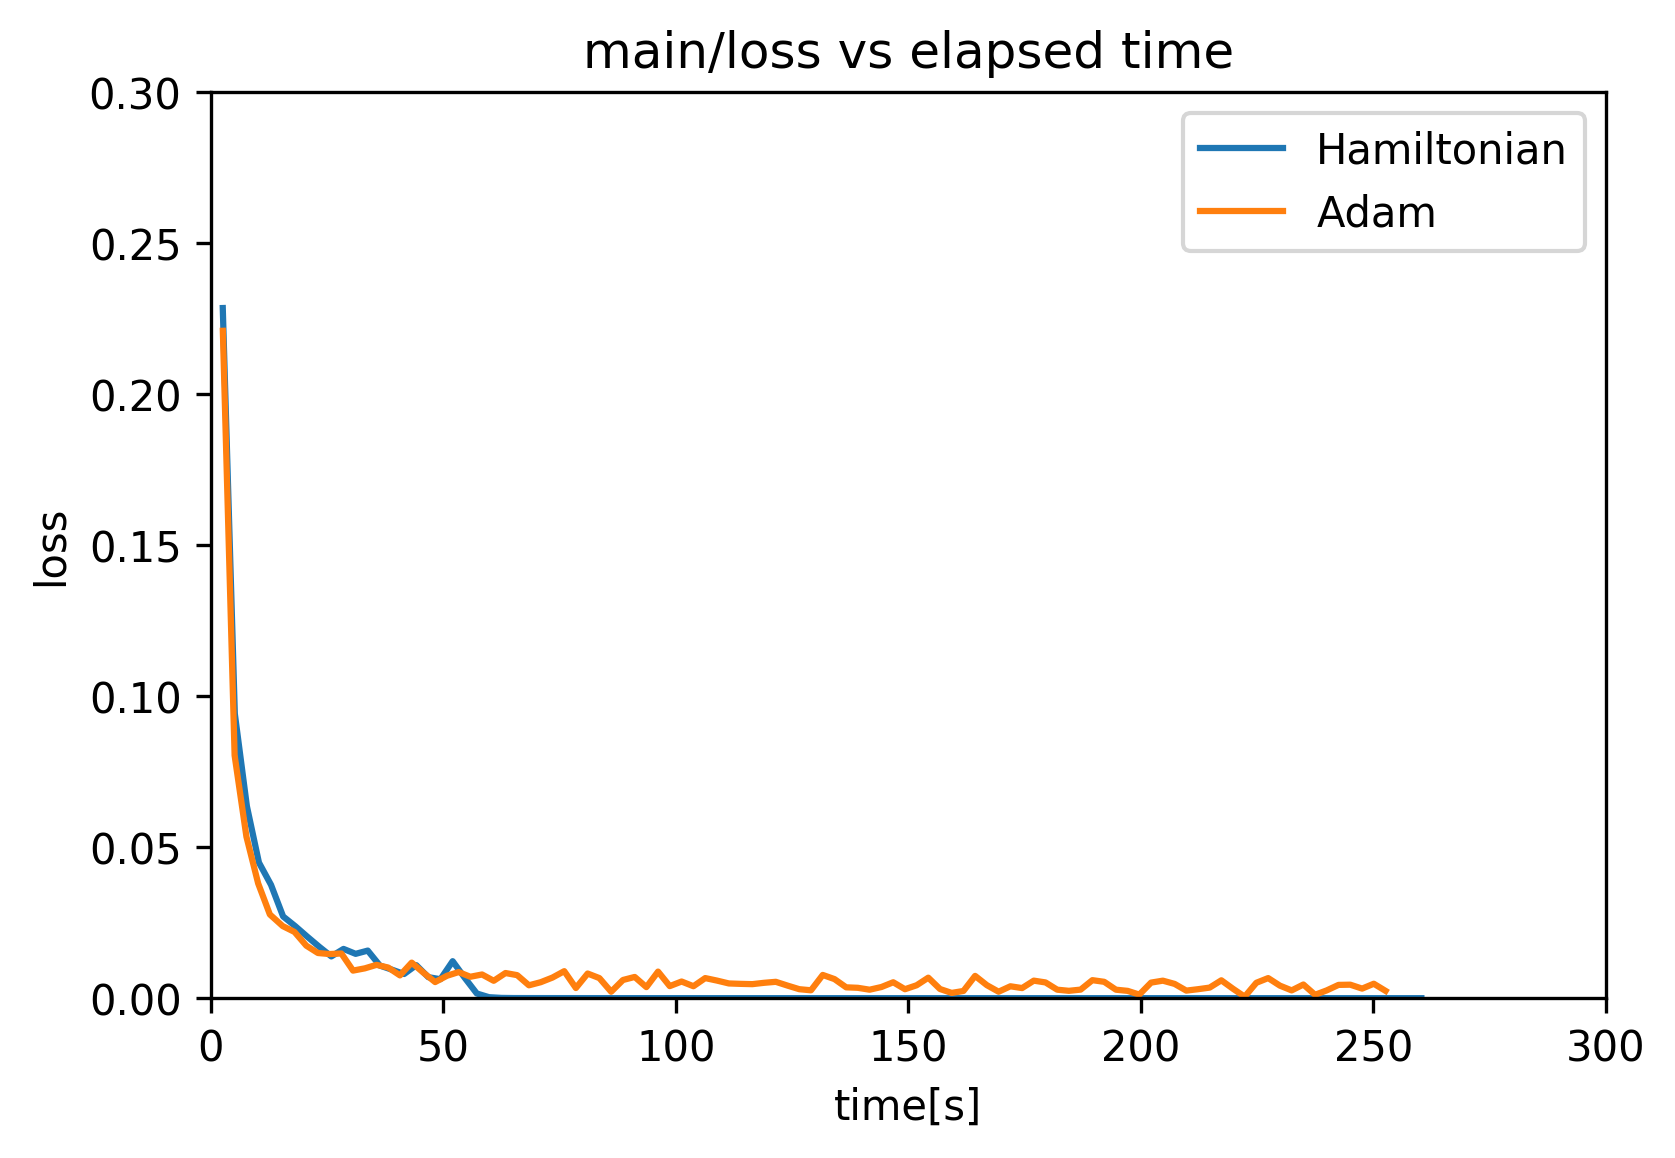

In [27]:
plt.figure(figsize=(6,4),dpi=300)
plt.ylim(0,.3)
plt.xlim(0,300)
plt.title("main/loss vs elapsed time")
plt.xlabel("time[s]")
plt.ylabel("loss")
plt.plot(hamiltonian_result["elapsed_time"],hamiltonian_result["main/loss"], label='Hamiltonian')
plt.plot(adam_result["elapsed_time"],adam_result["main/loss"], label='Adam')


plt.legend()

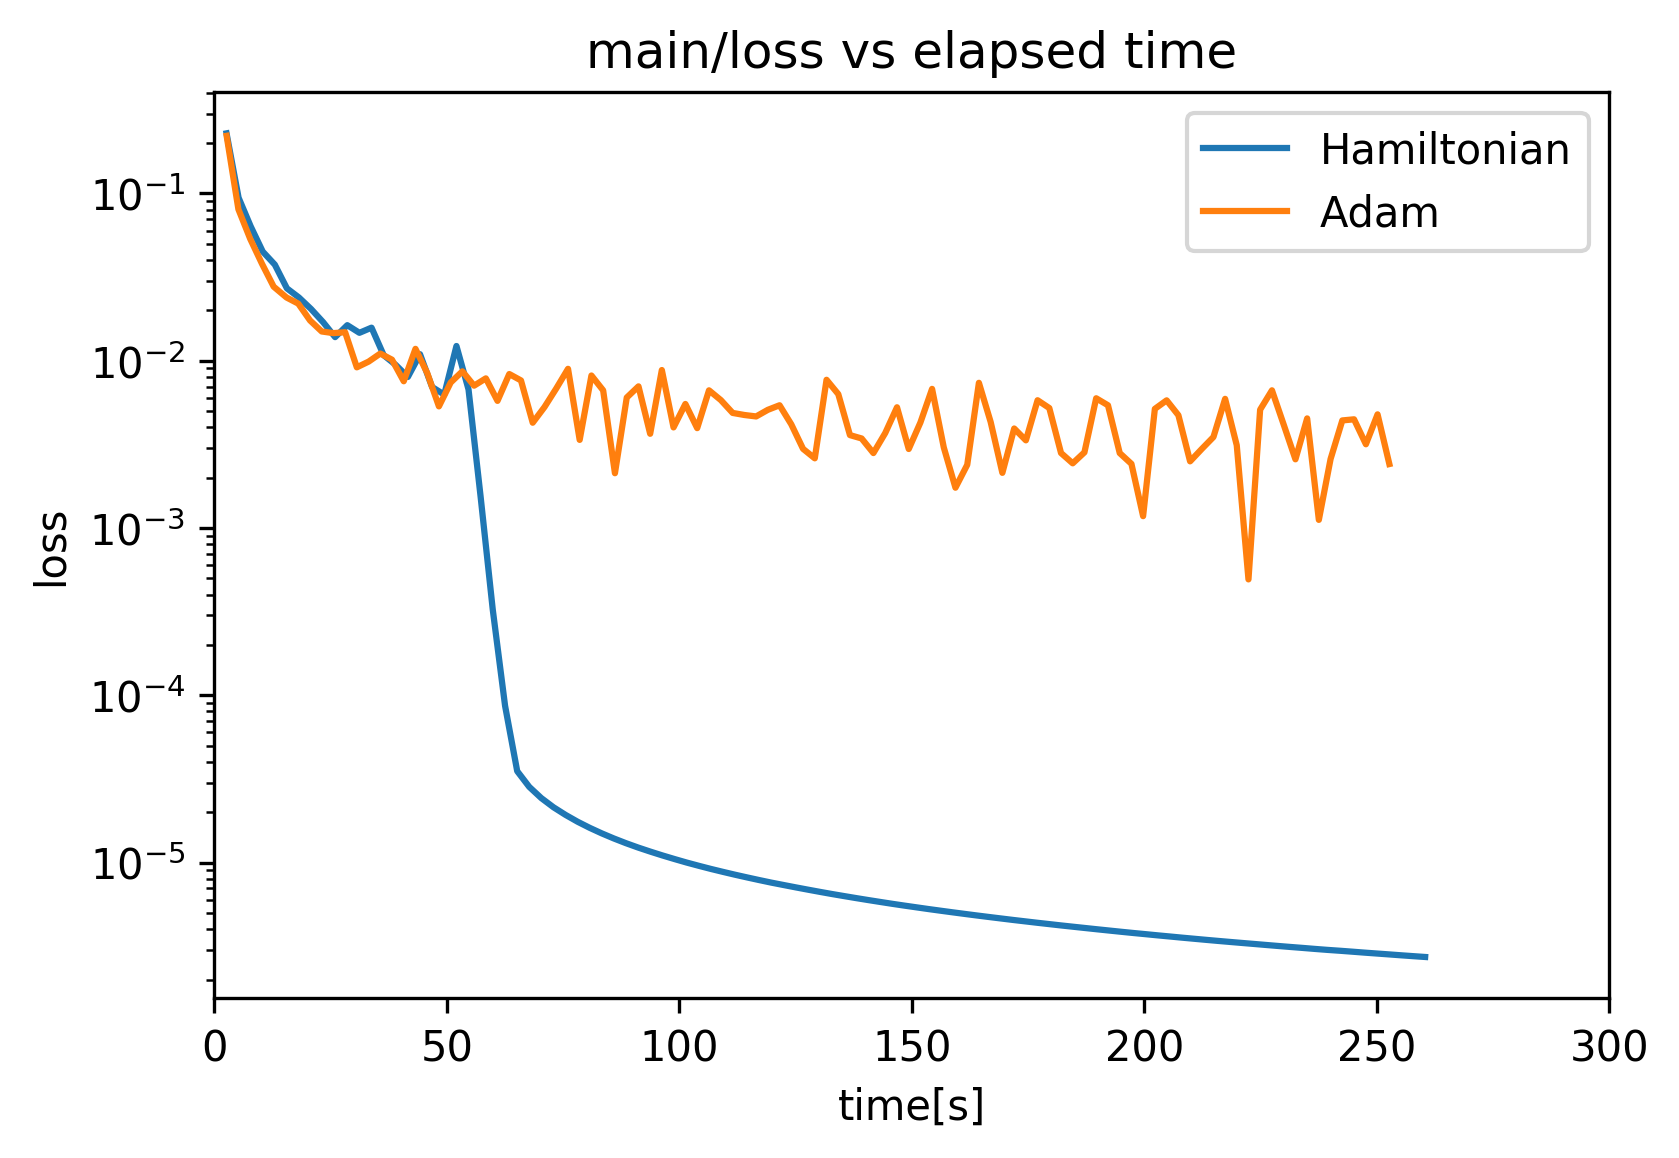

In [28]:
plt.figure(figsize=(6,4),dpi=300)
plt.yscale("log")
plt.xlim(0,300)
plt.title("main/loss vs elapsed time")
plt.xlabel("time[s]")
plt.ylabel("loss")
plt.plot(hamiltonian_result["elapsed_time"],hamiltonian_result["main/loss"], label='Hamiltonian')
plt.plot(adam_result["elapsed_time"],adam_result["main/loss"], label='Adam')


plt.legend()